In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import os
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolDescriptors
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



In [ ]:
def features(mol, l):
    try:
        mol_name = mol.GetProp('_Name')   # get the name 
        mol_weight = Descriptors.MolWt(mol) # measuring total mass of the molecule
        logp = Descriptors.MolLogP(mol)   # measuring of hydrophobicity
        h_bond_donors = rdMolDescriptors.CalcNumHBD(mol)  # getting number of hydrogen bond donors
        h_bond_acceptors = rdMolDescriptors.CalcNumHBA(mol)  # getting number of hydrogen bond acceptors
        rot_bonds = Descriptors.NumRotatableBonds(mol)   # check how single atom freely rotate
        tpsa = rdMolDescriptors.CalcTPSA(mol)  # 
        # Encoding of the atom 
        atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]   # getting the symbols 
        atom_array = np.array(atom_symbols).reshape(-1, 1)   # convert into a 2d shape array 
        known_atoms = ['C', 'H', 'N', 'O', 'F', 'Cl', 'Br', 'S', 'P']  
        encoder = OneHotEncoder(categories=[known_atoms], sparse_output=False, handle_unknown='ignore') # using encoder 
        encoder.fit(atom_array)  # build the encoder
        onehot_matrix = encoder.transform(atom_array)  
        summed_vector = onehot_matrix.sum(axis=0)
        features = {   # making a features dictionary
            "Name": mol_name,
            "MW": mol_weight,
            "LogP": logp,
            "HBD": h_bond_donors,
            "HBA": h_bond_acceptors,
            "RB": rot_bonds,
            "TPSA": tpsa,
            "Label": l
        }

        for atom, count in zip(known_atoms, summed_vector):
            features[f'OneHot_{atom}'] = int(count)

        return features
    except Exception as e:
        print(f"Invalid molecule: {e}")
        return 

In [3]:
def sdf_process(s, l):
    file = Chem.SDMolSupplier(s)   # loading the molecules 
    data = []     

    for mol in file:  # iteration through the file 
        if mol is None:
            continue
        result = features(mol, l)   # calls the function for each molecule
        if result:
            data.append(result)  # if it is not none append the results

    return pd.DataFrame(data)

In [4]:
def plot(df):
    plt.figure(figsize=(6, 4))  # setting the ploy size 
    plt.scatter(df['MW'], df['LogP'], c=df['Label'], cmap='bwr', alpha=0.7)    # scatter plot 
    plt.xlabel("Molecular Weight")  # setting the x 
    plt.ylabel("LogP")  # setting the y 
    plt.title("MW vs LogP (Red: Drug-like, Blue: Decoy)")  # setting the tittle
    plt.grid(True)  
    plt.tight_layout()
    plt.savefig("mw_vs_logp.png")
    plt.show()

    plt.figure(figsize=(6, 4))  # setting the ploy size 
    df.boxplot(column='TPSA', by='Label', grid=False)  # box plot 
    plt.title("TPSA by Label (0 = Decoy, 1 = Drug-like)")
    plt.suptitle("")
    plt.xlabel("Label")    # setting the x 
    plt.ylabel("TPSA")     # setting the y 
    plt.tight_layout()
    plt.savefig("tpsa_by_label.png")
    plt.show()

       Name        MW     LogP  HBD  HBA  RB    TPSA  Label  OneHot_C  \
0    129211   408.520  2.34090    2    6  11   99.88      1        20   
1    149096   361.373  1.54400    1    6   2   75.01      1        18   
2  16129678  1619.878 -6.80383   23   21  51  686.13      1        71   
3      1983   151.165  1.35060    2    2   1   49.33      1         8   
4      2083   239.315  1.30600    4    4   4   72.72      1        13   

   OneHot_H  OneHot_N  OneHot_O  OneHot_F  OneHot_Cl  OneHot_Br  OneHot_S  \
0         0         2         5         0          0          0         1   
1         0         3         4         1          0          0         0   
2         1        24        18         0          0          0         1   
3         0         1         2         0          0          0         0   
4         0         1         3         0          0          0         0   

   OneHot_P  
0         0  
1         0  
2         0  
3         0  
4         0  
Logistic Regre

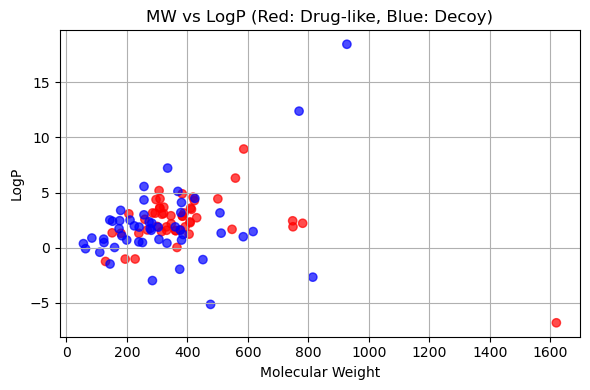

<Figure size 600x400 with 0 Axes>

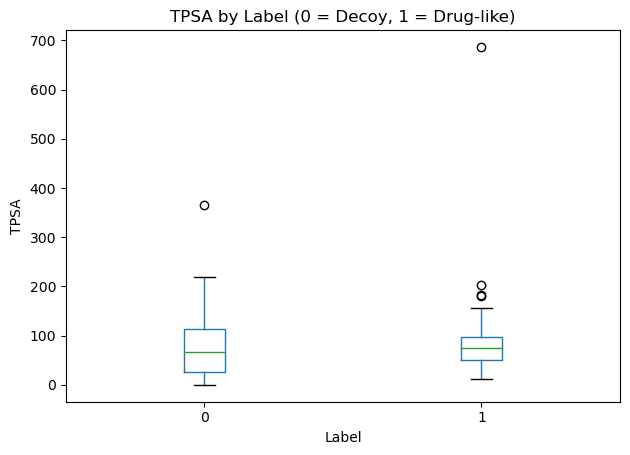

In [11]:
def main():
    drug_like = "Drug_like.sdf"
    non_drug_like = "Non_drug_like.sdf"
    drug_df = sdf_process(drug_like, l=1)   # 1 for drug 
    decoy_df = sdf_process(non_drug_like, l=0) # o for decoy 
    df = pd.concat([drug_df, decoy_df], ignore_index=True)    # merge two dataframes 
    df.to_csv("ligand_features_dataset.csv", index=False)  # making csv 
    print(df.head())  # printing head 
    X = df.drop(["Name", "Label"], axis=1)    # getting x 
    y = df["Label"]    # getting labels in the y 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)   # split into train and test 
    model = LogisticRegression(max_iter=1000, random_state=42)   # initialize the model 
    model.fit(X_train, y_train)   # train the model 
    y_pred = model.predict(X_test)   # test the model 
    print("Logistic Regression Results")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    plot(df)
if __name__ == "__main__":
    main()
